In [42]:
!pip install nltk spacy wordcloud transformers scikit-learn seaborn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [43]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [44]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import pickle

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
df = pd.read_csv("climate-fever.csv")

In [46]:
df.columns

Index(['claim_id', 'claim', 'claim_label', 'evidences/0/evidence_id',
       'evidences/0/evidence_label', 'evidences/0/article',
       'evidences/0/evidence', 'evidences/0/entropy', 'evidences/0/votes/0',
       'evidences/0/votes/1', 'evidences/0/votes/2', 'evidences/0/votes/3',
       'evidences/0/votes/4', 'evidences/1/evidence_id',
       'evidences/1/evidence_label', 'evidences/1/article',
       'evidences/1/evidence', 'evidences/1/entropy', 'evidences/1/votes/0',
       'evidences/1/votes/1', 'evidences/1/votes/2', 'evidences/1/votes/3',
       'evidences/1/votes/4', 'evidences/2/evidence_id',
       'evidences/2/evidence_label', 'evidences/2/article',
       'evidences/2/evidence', 'evidences/2/entropy', 'evidences/2/votes/0',
       'evidences/2/votes/1', 'evidences/2/votes/2', 'evidences/2/votes/3',
       'evidences/2/votes/4', 'evidences/3/evidence_id',
       'evidences/3/evidence_label', 'evidences/3/article',
       'evidences/3/evidence', 'evidences/3/entropy', 'evide

In [47]:
df.head()

,claim_id,claim,claim_label,evidences/0/evidence_id,evidences/0/evidence_label,evidences/0/article,evidences/0/evidence,evidences/0/entropy,evidences/0/votes/0,evidences/0/votes/1,...,evidences/4/evidence_id,evidences/4/evidence_label,evidences/4/article,evidences/4/evidence,evidences/4/entropy,evidences/4/votes/0,evidences/4/votes/1,evidences/4/votes/2,evidences/4/votes/3,evidences/4/votes/4
0,0,Global warming is driving polar bears toward e...,SUPPORTS,Extinction risk from global warming:170,NOT_ENOUGH_INFO,Extinction risk from global warming,"""Recent Research Shows Human Activity Driving ...",0.693147,SUPPORTS,NOT_ENOUGH_INFO,...,Polar bear:1328,NOT_ENOUGH_INFO,Polar bear,"""Bear hunting caught in global warming debate"".",0.693147,SUPPORTS,NOT_ENOUGH_INFO,NaN,NaN,NaN
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,Famine:386,SUPPORTS,Famine,The current consensus of the scientific commun...,0.000000,SUPPORTS,SUPPORTS,...,Winter:5,NOT_ENOUGH_INFO,Winter,"In many regions, winter is associated with sno...",0.693147,REFUTES,NOT_ENOUGH_INFO,NaN,NaN,NaN
2,6,The polar bear population has been growing.,REFUTES,Polar bear:1332,NOT_ENOUGH_INFO,Polar bear,"""Ask the experts: Are polar bear populations i...",0.693147,NOT_ENOUGH_INFO,REFUTES,...,Polar bear:61,REFUTES,Polar bear,Of the 19 recognized polar bear subpopulations...,0.000000,REFUTES,REFUTES,NaN,NaN,NaN
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,Atmosphere of Mars:131,NOT_ENOUGH_INFO,Atmosphere of Mars,CO2 in the mesosphere acts as a cooling agent ...,0.693147,NOT_ENOUGH_INFO,SUPPORTS,...,Carbon dioxide:191,NOT_ENOUGH_INFO,Carbon dioxide,"Less energy reaches the upper atmosphere, whic...",0.000000,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,NaN,NaN,NaN
4,10,Human additions of CO2 are in the margin of er...,REFUTES,Carbon dioxide in Earth's atmosphere:140,NOT_ENOUGH_INFO,Carbon dioxide in Earth's atmosphere,While CO 2 absorption and release is always ha...,0.693147,NOT_ENOUGH_INFO,REFUTES,...,Sea:226,REFUTES,Sea,"More recently, anthropogenic activities have s...",0.000000,REFUTES,REFUTES,NaN,NaN,NaN


In [48]:
df['claim_label'] = df['claim_label'].map({
    'SUPPORTS': 1,
    'REFUTES': 0,
    'NOT_ENOUGH_INFO': 2
})

this is binary classification, That means:

We must remove NOT_ENOUGH_INFO.

In [49]:
df['claim_label'].unique()

array([ 1.,  0.,  2., nan])

In [50]:
df = df.dropna(subset=['claim_label'])

In [51]:
df['claim_label'] = df['claim_label'].astype(int)

In [52]:
df.shape

(1381, 53)

In [53]:
df = df[df['claim_label'] != 2]

In [54]:
df['claim_label'].value_counts()

,count
claim_label,
1,654
0,253


1 → 654 samples (SUPPORTS) YES

0 → 253 samples (REFUTES) NO

In [55]:
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove smart quotes/apostrophes and ellipses
    text = re.sub(r'[‘’“”…]', '', text)
    # Remove newlines
    text = re.sub(r'\n', '', text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [56]:
df['clean_text'] = df['claim'].apply(clean_text)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['claim_label'],
    test_size=0.2,
    random_state=42
)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [59]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04        50
           1       0.73      1.00      0.84       132

    accuracy                           0.73       182
   macro avg       0.86      0.51      0.44       182
weighted avg       0.80      0.73      0.62       182



The initial model showed high accuracy (73%) but poor recall for the REFUTES class due to **dataset imbalance**. After applying class_weight='balanced', the model improved minority class detection performance.


Recreate model with **balancing**

In [61]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')

In [62]:
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [63]:
y_pred = model.predict(X_test_tfidf)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.48      0.46        50
           1       0.80      0.77      0.78       132

    accuracy                           0.69       182
   macro avg       0.62      0.62      0.62       182
weighted avg       0.70      0.69      0.69       182



The initial Logistic Regression model achieved 73% accuracy but showed extremely poor recall (0.02) for the REFUTES class. This indicated strong bias toward the majority class (SUPPORTS).

To address this, class_weight='balanced' was applied, which assigns higher penalty to minority class misclassification.

After applying balancing:

Recall for REFUTES improved from 0.02 → 0.48

F1-score for REFUTES improved significantly

Overall accuracy slightly reduced (73% → 69%), but model fairness improved

This demonstrates that accuracy alone is not a reliable metric for imbalanced datasets.

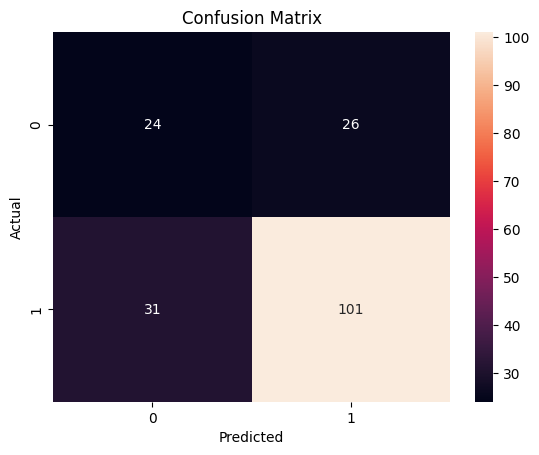

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

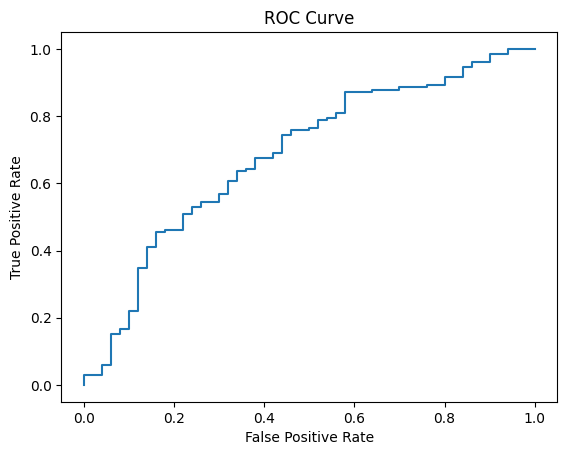

AUC Score: 0.6840909090909091


In [66]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test_tfidf)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

print("AUC Score:", roc_auc)

In [67]:
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

top_positive = sorted(zip(coefficients, feature_names), reverse=True)[:10]
top_negative = sorted(zip(coefficients, feature_names))[:10]

print("Top words predicting SUPPORTS:")
for coef, word in top_positive:
    print(word)

print("\nTop words predicting REFUTES:")
for coef, word in top_negative:
    print(word)

Top words predicting SUPPORTS:
trend
research
water
loss
changes
said
find
two
surface
scale

Top words predicting REFUTES:
increase
isnt
rise
life
us
carbon
temperature
insignificant
kills
manmade


In [68]:
import pickle
pickle.dump(model, open("climate_model.pkl", "wb"))